# Import libraries & Read csv

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kurtosis, skew, pearsonr, spearmanr
from statsmodels.graphics.gofplots import qqplot

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv("/content/drive/My Drive/OpenClassrooms/P2/P2_openfoodfacts_exploration.csv")

# Univariate Analysis

In [ ]:
df.shape

(204840, 20)

In [ ]:
df.describe()

,code,additives_n,nutriscore_score,nova_group,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g
count,2.048400e+05,193121.000000,197831.000000,182373.000000,181535.000000,204840.000000,204840.000000,202699.000000,204840.000000,203760.000000,204840.000000,204840.000000,203897.000000,203896.000000,197831.000000
mean,2.165580e+12,1.614635,5.583129,3.321703,209.820309,875.032875,8.099083,2.735196,27.015596,9.153213,1.835582,6.645158,0.758178,0.303272,5.583129
std,2.651589e+12,1.924658,8.559669,1.039789,158.692503,663.321511,10.308587,4.090280,26.357979,11.680585,2.063031,6.177745,0.743109,0.297242,8.559669
min,5.000000e+00,0.000000,-15.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000
25%,5.042849e+10,0.000000,-1.000000,3.000000,65.000000,276.000000,0.500000,0.000000,5.770000,1.200000,0.000000,1.590000,0.100000,0.040000,-1.000000
50%,7.839630e+11,1.000000,3.000000,4.000000,170.000000,702.000000,3.300000,0.700000,14.000000,3.890000,1.200000,5.260000,0.620000,0.248000,3.000000
75%,3.523680e+12,3.000000,12.000000,4.000000,353.000000,1477.000000,13.000000,3.600000,50.000000,12.000000,3.000000,10.000000,1.172500,0.469000,12.000000
max,1.078562e+13,7.000000,35.000000,4.000000,848.000000,3548.000000,52.630000,17.850000,100.000000,48.330000,9.000000,28.200000,3.315000,1.326000,35.000000


In [ ]:
df.isnull().sum()

code                           0
product_name                 648
categories                     0
additives_n                11719
nutriscore_score            7009
nutriscore_grade            7009
nova_group                 22467
pnns_groups_1                  0
pnns_groups_2                  0
energy-kcal_100g           23305
energy_100g                    0
fat_100g                       0
saturated-fat_100g          2141
carbohydrates_100g             0
sugars_100g                 1080
fiber_100g                     0
proteins_100g                  0
salt_100g                    943
sodium_100g                  944
nutrition-score-fr_100g     7009
dtype: int64

There are still some null values. We will address them later using  KNN Imputer algorithm.

In [ ]:
col_pnns_1 = ['fruits-and-vegetables', 'cereals-and-potatoes', 'composite-foods',  'milk-and-dairy-products', 'fish-meat-eggs', 'fat-and-sauces', 'beverages', 'salty-snacks', 'sugary-snacks']

In [ ]:
df[df['pnns_groups_1']=='sugary-snacks']['nutriscore_grade'].value_counts().sort_index()


a      471
b     1017
c     4224
d    10788
e    11240
Name: nutriscore_grade, dtype: int64

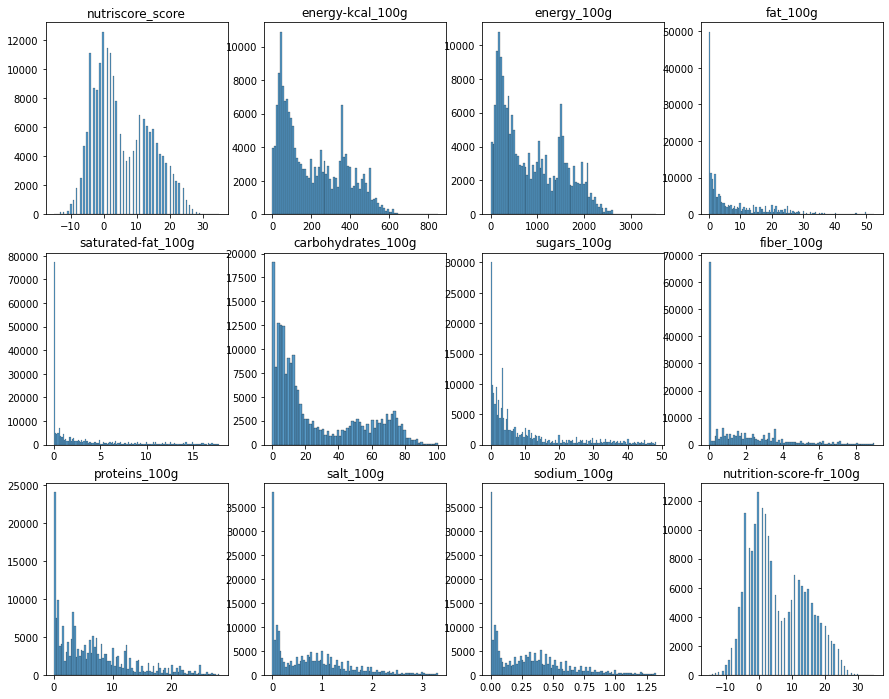

In [ ]:
col_continuous = ['nutriscore_score',
       'energy-kcal_100g', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g']

fig, axes = plt.subplots(3,4, figsize=(15,12))
y=0
for col in col_continuous:
    i,j = divmod(y,4)
    sns.histplot(ax = axes[i,j], x=df[col])#, x=food_clean.nutriscore_grade, order=['a', 'b', 'c', 'd', 'e'])
    axes[i,j].set_title(col)
    axes[i,j].set_ylabel('')  
    axes[i,j].set_xlabel('')

    y=y+1

In [ ]:
df.pnns_groups_1.value_counts()

cereals-and-potatoes       36769
sugary-snacks              29562
composite-foods            24343
fruits-and-vegetables      23776
milk-and-dairy-products    23625
fish-meat-eggs             21597
beverages                  19821
fat-and-sauces             18970
salty-snacks                6377
Name: pnns_groups_1, dtype: int64

Text(0.5, 1.0, 'Count per product category')

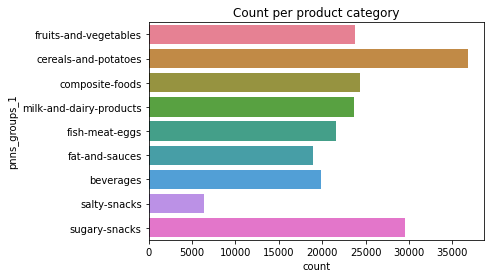

In [ ]:
sns.countplot(y=df['pnns_groups_1'].sort_index(), order = col_pnns_1, palette='husl')
plt.title("Count per product category")

Product categories more represented are 'cereals and potatoes' and 'snacks' followed by 'fruits', 'composite foods' and 'dairy products'. 'Fat and sauces' and 'beverages' are the least represented.
However, there are large enough data for each category.

Text(0.5, 1.0, 'Nutriscore distribution within the dataset')

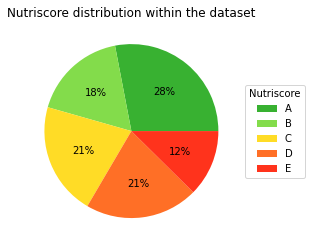

In [ ]:
colors = ['#38B131','#83DC4B','#FFDC26','#FF6F26', '#FF331C']
plt.pie(df['nutriscore_grade'].value_counts().sort_index(), autopct='%1.f%%', colors=colors)
plt.legend(['A', 'B', 'C', 'D', 'E'],
          title="Nutriscore",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.title("Nutriscore distribution within the dataset")

The nutriscore distriution is highlighted in the pie chart above. A-grade products are the most represented. B, C and D grade products represent each roughly 20% of all products.
E grade products are the least represented with 12%.




# Multivariate analysis

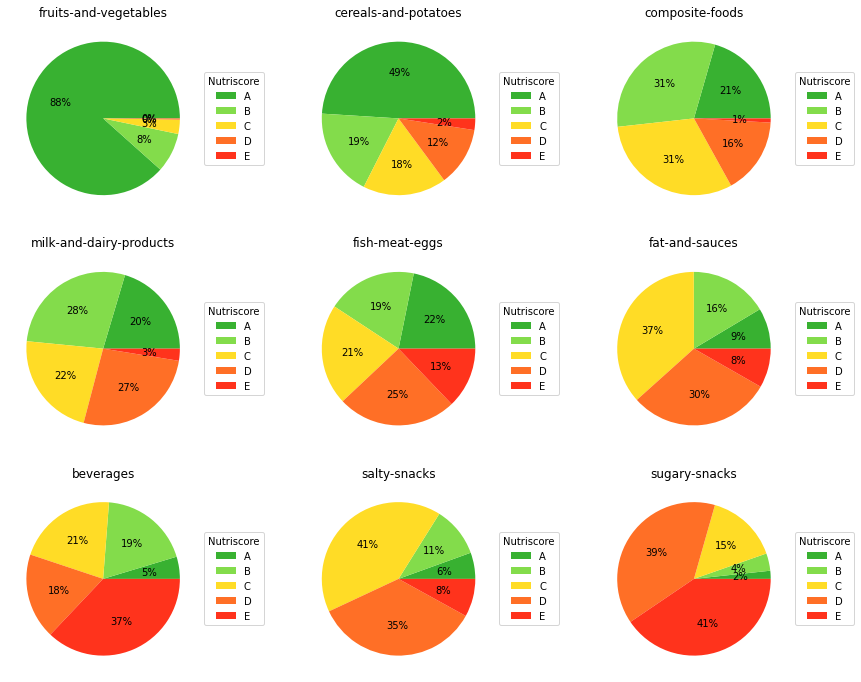

In [ ]:
fig, axes = plt.subplots(3,3, figsize=(15,12))
cmap = plt.get_cmap("hsv") #tab20c

y=0
for col in col_pnns_1:
    i,j = divmod(y,3)
    axes[i,j].pie(df[df['pnns_groups_1']==col]['nutriscore_grade'].value_counts().sort_index(), autopct='%1.f%%', colors=colors)#cmap([70,60,40,20,0]))
    # sns.histplot(ax = axes[i,j], x=df[col])#, x=food_clean.nutriscore_grade, order=['a', 'b', 'c', 'd', 'e'])
    axes[i,j].set_title(col)
    axes[i,j].legend(['A', 'B', 'C', 'D', 'E'],
          title="Nutriscore",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
    # axes[i,j].set_ylabel('')  
    # axes[i,j].set_xlabel('')

    y=y+1

The graphic above shows the nutriscore distribution for each product category. It is not surprising to see that 'fruits-vegetables' category has a large proportion of healthy products. Conversely, 'snacks' and 'beverages' categories contain mainly unhealthy products.

In [ ]:
# generate random indexes
rand_ind = df.sample(n=300, random_state=10).index
rand_ind

Int64Index([171662, 149659, 183343, 204444, 126538,  79960,  29718,  45131,
             52337,  22965,
            ...
            142278, 181624, 130498, 146385,  14256, 100770,  90959, 120619,
             15012,  19720],
           dtype='int64', length=300)

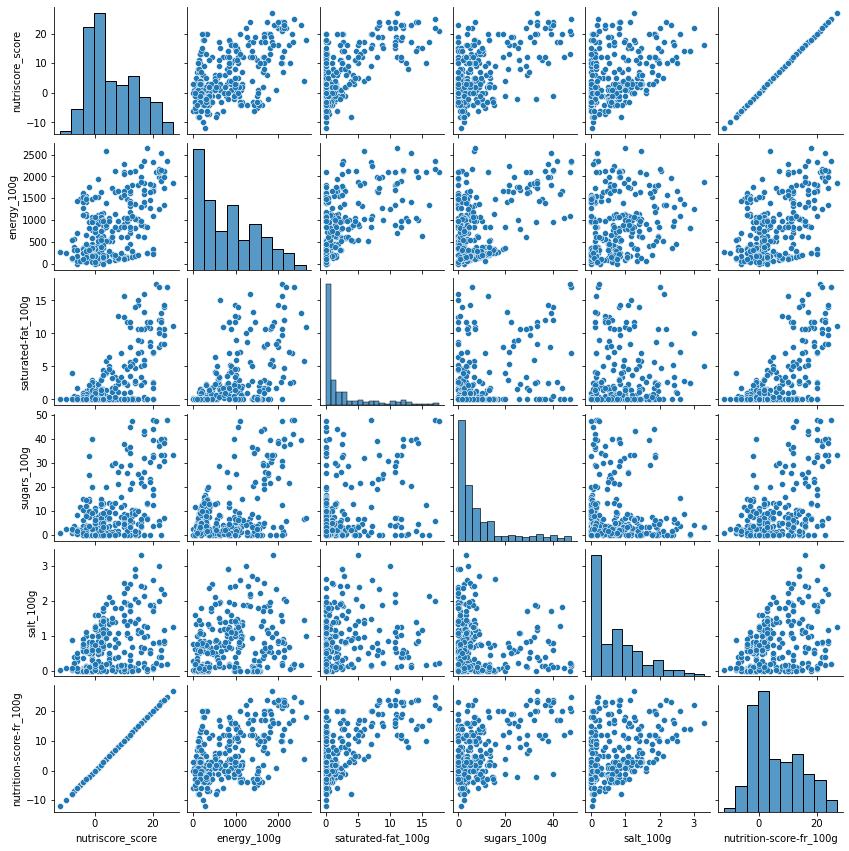

In [ ]:
col_pairlot1 = ['nutriscore_score','energy_100g','saturated-fat_100g','sugars_100g','salt_100g','nutrition-score-fr_100g' ]
sns.pairplot(df[col_pairlot1].iloc[rand_ind,:], height=2)

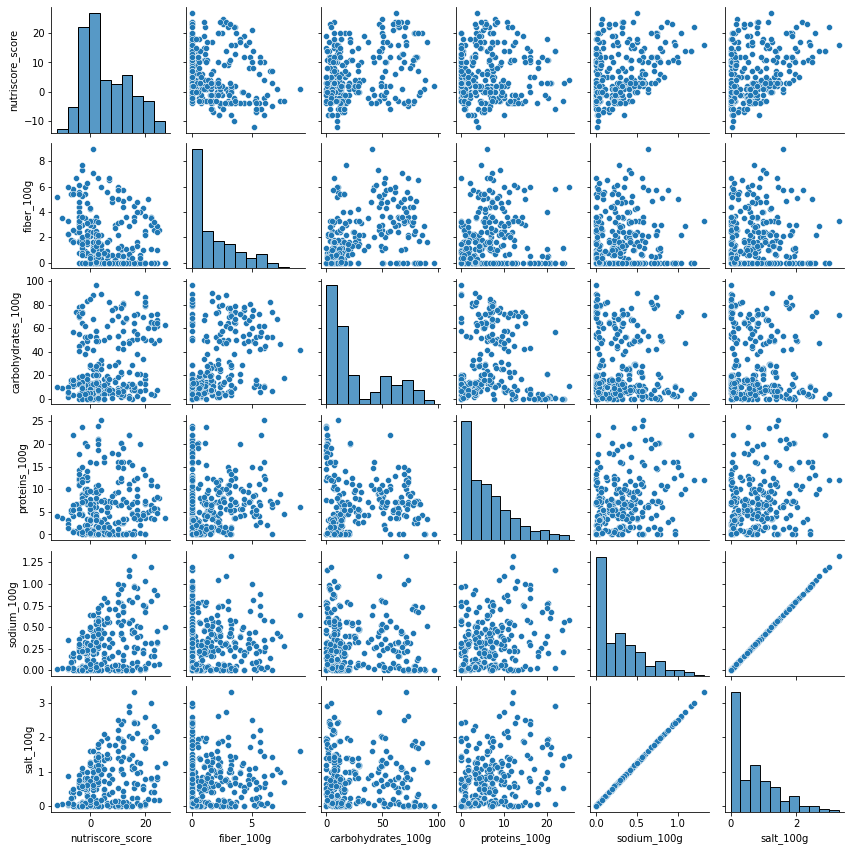

In [ ]:
col_pairlot2 = ['nutriscore_score','fiber_100g','carbohydrates_100g','proteins_100g','sodium_100g','salt_100g']
sns.pairplot(df[col_pairlot2].iloc[rand_ind,:], height=2)

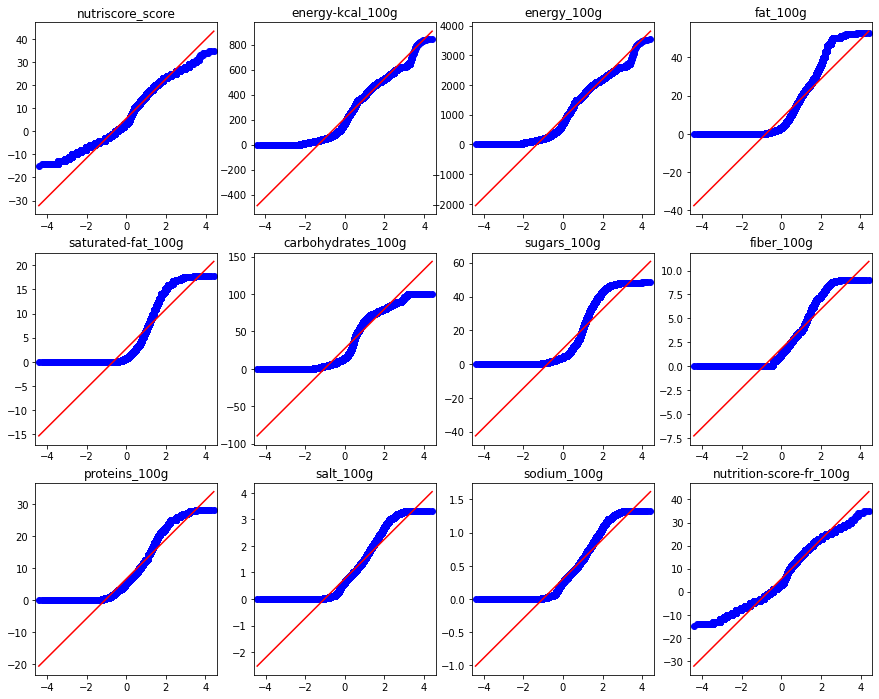

In [ ]:
fig, axes = plt.subplots(3,4, figsize=(15,12))
y=0
for col in col_continuous:
    i,j = divmod(y,4)
    qqplot(df[col].dropna(), line='s',ax = axes[i,j])  #drop null values otherwise non-finite values error
    axes[i,j].set_title(col)
    axes[i,j].set_ylabel('')  
    axes[i,j].set_xlabel('')

    y=y+1


Distributions and qq plots are helpful to visualize the normality of the sample. There are also statistical tests that help determine if the distriution is gaussian like. Just to name a few:

  - Shapiro-Wilk test (N > 5000)

  - D'Agostino's K^2 test

  - Anderson-Darling test

None of the quantitative variables have a normal distribution based on the visualization plots. However, I will use normality test to confirm that.

We start by defining the null hypothesis: 

H0: "The variable is drawn by a Gaussian distribution."

A threshold level is chosen called alpha, typically 5% (or 0.05), that is used to interpret the p-value.

p <= alpha: reject H0, not normal.

p > alpha: fail to reject H0, normal.

Shapiro-Wilk test not being robust for samples > 5000, I will be using D'Agostino K^2.

In [ ]:
# from scipy.stats import shapiro
# # normality test
# stat, p = shapiro(df['energy-kcal_100g'].dropna())
# print('Statistics=%.3f, p=%.3f' % (stat, p))
# # interpret
# alpha = 0.05
# if p > alpha:
# 	print('Sample looks Gaussian (fail to reject H0)')
# else:
# 	print('Sample does not look Gaussian (reject H0)')

In [ ]:
from scipy.stats import normaltest
normality = {}
for col in col_continuous:

	# normality test
		stat, p = normaltest(df[col].dropna())
		# print('Statistics=%.3f, p=%.3f' % (stat, p))
	# interpret
		alpha = 0.05
		if p > alpha:
			# print('{} looks Gaussian (fail to reject H0)'.format(col))
	 		normality[col] = 'Normally distributed'
		else:
			# print('{} does not look Gaussian (reject H0)'.format(col))
	 		normality[col] = 'Not normally distributed'
normality

{'carbohydrates_100g': 'Not normally distributed',
 'energy-kcal_100g': 'Not normally distributed',
 'energy_100g': 'Not normally distributed',
 'fat_100g': 'Not normally distributed',
 'fiber_100g': 'Not normally distributed',
 'nutriscore_score': 'Not normally distributed',
 'nutrition-score-fr_100g': 'Not normally distributed',
 'proteins_100g': 'Not normally distributed',
 'salt_100g': 'Not normally distributed',
 'saturated-fat_100g': 'Not normally distributed',
 'sodium_100g': 'Not normally distributed',
 'sugars_100g': 'Not normally distributed'}

As expected, none of the quantitative variables are Gaussian like. Actually, some are bi-modal, others are badly skewed. 

**In that case I  will be using spearman method to compute the correlation matrix.**

In [ ]:
# from scipy.stats import anderson
# # normality test
# result = anderson(df['energy-kcal_100g'].dropna())
# print('Statistic: %.3f' % result.statistic)
# p = 0
# for i in range(len(result.critical_values)):
# 	sl, cv = result.significance_level[i], result.critical_values[i]
# 	if result.statistic < result.critical_values[i]:
# 		print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
# 	else:
# 		print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

In [ ]:
col_num = ['additives_n', 'nova_group', 'fat_100g',
       'proteins_100g', 'carbohydrates_100g', 'fiber_100g', 'salt_100g', 'saturated-fat_100g', 'sugars_100g',
         'energy-kcal_100g', 'nutriscore_score'
       ]
correlation = df[col_num].corr(method='spearman')
correlation

,additives_n,nova_group,fat_100g,proteins_100g,carbohydrates_100g,fiber_100g,salt_100g,saturated-fat_100g,sugars_100g,energy-kcal_100g,nutriscore_score
additives_n,1.000000,0.654799,0.256173,0.002975,0.141642,-0.092183,0.268203,0.251943,0.241570,0.203360,0.390777
nova_group,0.654799,1.000000,0.284039,0.039105,0.105796,-0.106877,0.337316,0.287884,0.215025,0.201463,0.432203
fat_100g,0.256173,0.284039,1.000000,0.496225,0.190112,0.125501,0.451944,0.870387,0.080730,0.741781,0.582953
proteins_100g,0.002975,0.039105,0.496225,1.000000,0.119271,0.178147,0.361808,0.397887,-0.262789,0.541702,0.058856
carbohydrates_100g,0.141642,0.105796,0.190112,0.119271,1.000000,0.503436,-0.040625,0.093093,0.515242,0.681573,0.205193
fiber_100g,-0.092183,-0.106877,0.125501,0.178147,0.503436,1.000000,0.004697,-0.002797,0.121499,0.329890,-0.243960
salt_100g,0.268203,0.337316,0.451944,0.361808,-0.040625,0.004697,1.000000,0.333393,-0.175400,0.306584,0.440608
saturated-fat_100g,0.251943,0.287884,0.870387,0.397887,0.093093,-0.002797,0.333393,1.000000,0.129333,0.588497,0.599027
sugars_100g,0.241570,0.215025,0.080730,-0.262789,0.515242,0.121499,-0.175400,0.129333,1.000000,0.268042,0.382201
energy-kcal_100g,0.203360,0.201463,0.741781,0.541702,0.681573,0.329890,0.306584,0.588497,0.268042,1.000000,0.510062


In [ ]:
correlation.nutriscore_score.sort_values(ascending=False)

nutriscore_score      1.000000
saturated-fat_100g    0.599027
fat_100g              0.582953
energy-kcal_100g      0.510062
salt_100g             0.440608
nova_group            0.432203
additives_n           0.390777
sugars_100g           0.382201
carbohydrates_100g    0.205193
proteins_100g         0.058856
fiber_100g           -0.243960
Name: nutriscore_score, dtype: float64


Nutriscore is:
1.   highly correlated to both fats, energy, salt, nova group, additives_n and sugars.
2.   not much correlated to proteins and complex sugars.
3.   moderately anti-correlated to fiber.






[Text(0.5, 0, 'additives_n'),
 Text(1.5, 0, 'nova_group'),
 Text(2.5, 0, 'fat_100g'),
 Text(3.5, 0, 'proteins_100g'),
 Text(4.5, 0, 'carbohydrates_100g'),
 Text(5.5, 0, 'fiber_100g'),
 Text(6.5, 0, 'salt_100g'),
 Text(7.5, 0, 'saturated-fat_100g'),
 Text(8.5, 0, 'sugars_100g'),
 Text(9.5, 0, 'energy-kcal_100g'),
 Text(10.5, 0, 'nutriscore_score')]

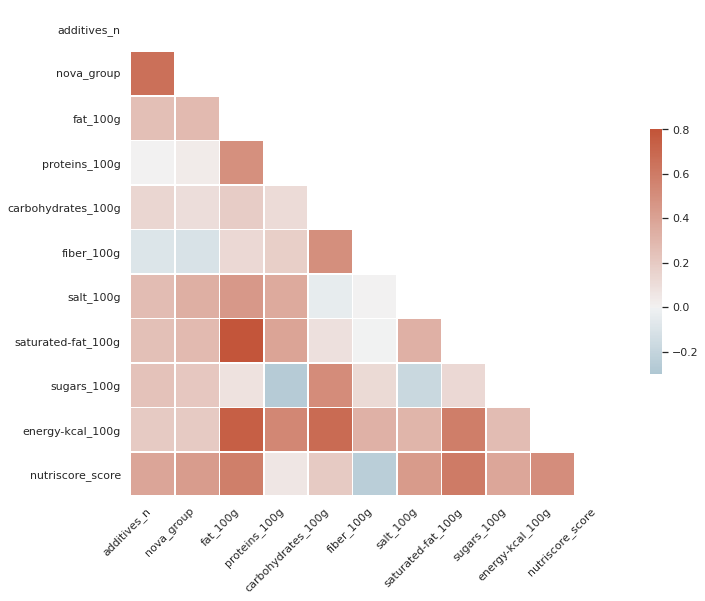

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Compute the correlation matrix
corr = df[col_num].corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.8, center=0, vmin=-.3,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

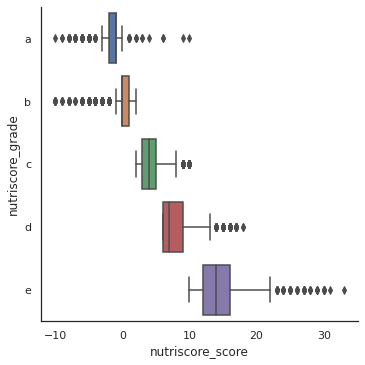

In [ ]:
sns.catplot(x='nutriscore_score', y='nutriscore_grade', kind='box', data=df[df['pnns_groups_1']=='beverages'], order=['a','b','c','d','e'])

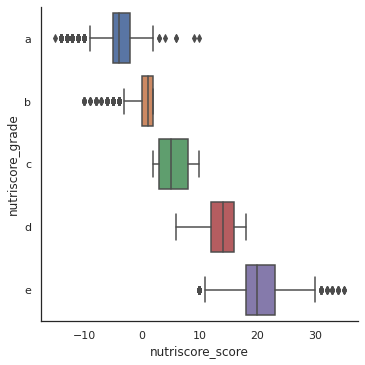

In [ ]:
sns.catplot(x='nutriscore_score', y='nutriscore_grade', kind='box', data=df, order=['a','b','c','d','e'])

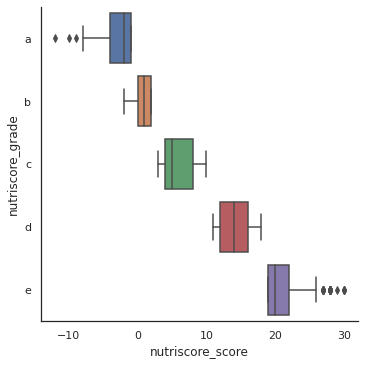

In [ ]:
sns.catplot(x='nutriscore_score', y='nutriscore_grade', kind='box', data=df[df['pnns_groups_1']=='fat-and-sauces'], order=['a','b','c','d','e'])

# Imputation

In [ ]:
df.isnull().sum()

code                           0
product_name                 648
categories                     0
additives_n                11719
nutriscore_score            7009
nutriscore_grade            7009
nova_group                 22467
pnns_groups_1                  0
pnns_groups_2                  0
energy-kcal_100g           23305
energy_100g                    0
fat_100g                       0
saturated-fat_100g          2141
carbohydrates_100g             0
sugars_100g                 1080
fiber_100g                     0
proteins_100g                  0
salt_100g                    943
sodium_100g                  944
nutrition-score-fr_100g     7009
dtype: int64

Null values imputation strategy:

  - use energy_100g to replace NaN from energy-kcal_100g

  - use KNN Imputer to replace NaN from all other numerical variables.

We don't need to address null values from product_name & categores variables.

**energy imputation**

In [ ]:
df['energy-kcal_100g'] = df['energy-kcal_100g'].fillna(df['energy_100g']/4.184)

In [ ]:
df.isna().sum()

code                           0
product_name                 648
categories                     0
additives_n                11719
nutriscore_score            7009
nutriscore_grade            7009
nova_group                 22467
pnns_groups_1                  0
pnns_groups_2                  0
energy-kcal_100g               0
energy_100g                    0
fat_100g                       0
saturated-fat_100g          2141
carbohydrates_100g             0
sugars_100g                 1080
fiber_100g                     0
proteins_100g                  0
salt_100g                    943
sodium_100g                  944
nutrition-score-fr_100g     7009
dtype: int64

In [ ]:
df.columns

Index(['code', 'product_name', 'categories', 'additives_n', 'nutriscore_score',
       'nutriscore_grade', 'nova_group', 'pnns_groups_1', 'pnns_groups_2',
       'energy-kcal_100g', 'energy_100g', 'fat_100g', 'saturated-fat_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g'],
      dtype='object')

In [ ]:
col_cat = ['code', 'product_name', 'categories',
       'nutriscore_grade', 'pnns_groups_1', 'pnns_groups_2']

In [ ]:
col_imputer = ['additives_n', 'nutriscore_score',
       'nova_group',
       'energy-kcal_100g', 'fat_100g', 'saturated-fat_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g']

**Standardization**

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_knn = pd.DataFrame(scaler.fit_transform(df[col_imputer]), columns=col_imputer)

**KNN Imputing**

In [ ]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
df_knn = pd.DataFrame(imputer.fit_transform(df_knn), columns=df_knn.columns)

In [ ]:
df_knn.isnull().sum()

additives_n           0
nutriscore_score      0
nova_group            0
energy-kcal_100g      0
fat_100g              0
saturated-fat_100g    0
carbohydrates_100g    0
sugars_100g           0
fiber_100g            0
proteins_100g         0
salt_100g             0
dtype: int64

In [ ]:
df_final = pd.concat([df_knn, df[col_cat]], axis=1)
df_final.shape

(204840, 17)

In [ ]:
# df_knn_inv = pd.DataFrame(scaler.inverse_transform(df_knn), columns=df_knn.columns)
# df_knn_inv.head(3)

#Train and Test

In [ ]:
features = ['energy-kcal_100g', 'fat_100g','saturated-fat_100g',
          'sugars_100g', 'fiber_100g', 'salt_100g']
col_pnns_1

['fruits-and-vegetables',
 'cereals-and-potatoes',
 'composite-foods',
 'milk-and-dairy-products',
 'fish-meat-eggs',
 'fat-and-sauces',
 'beverages',
 'salty-snacks',
 'sugary-snacks']

## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


X = df_final[features]
y = df_final['nutriscore_score']

lr = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

score = r2_score(prediction, y_test)
score

0.7665355010575479

Let's run the model for each product category to understand why the r2 score is not higher.

## Linear Regression (per product category)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

accuracy = {}

for col in col_pnns_1:

  X = df_final[df_final['pnns_groups_1'] == col][features]
  y = df_final[df_final['pnns_groups_1'] == col]['nutriscore_score']

  lr = LinearRegression()

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

  lr.fit(X_train, y_train)
  prediction = lr.predict(X_test)

  score = r2_score(prediction, y_test)
  accuracy[col] = np.round(score,2)

accuracy

{'beverages': -0.66,
 'cereals-and-potatoes': 0.92,
 'composite-foods': 0.82,
 'fat-and-sauces': 0.92,
 'fish-meat-eggs': 0.95,
 'fruits-and-vegetables': 0.75,
 'milk-and-dairy-products': 0.94,
 'salty-snacks': 0.75,
 'sugary-snacks': 0.93}

In [ ]:
beverages = df_final[df_final['pnns_groups_1'] == 'beverages']['pnns_groups_2']

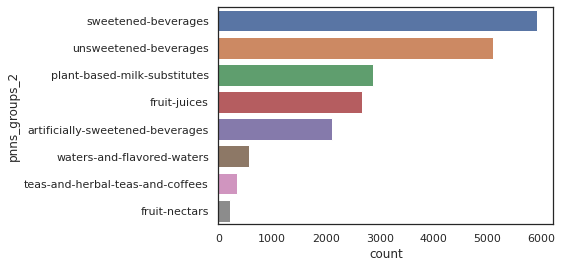

In [ ]:
sns.countplot(y = beverages)

In [ ]:
fruits_veg = df_final[df_final['pnns_groups_1'] == 'fruits-and-vegetables']['pnns_groups_2']

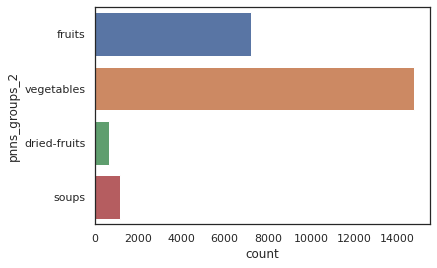

In [ ]:
sns.countplot(y = fruits_veg)

The accuracy for beverages is really bad. %fruits, vegetables,... is an important factor to compute the nutriscore for beverages. However, we dont have enough data in the openfoodfacts dataset so I decided to skik this variable.

Unless, we can get collect more data about the %fruits,... we won't be able to model accurately the nutriscore of beverages.

Here is a limitation for our app. **Consequently, the app will be relevant for all product types except beverages.**

## Linear Regression (all products except beverages)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


X = df_final[df_final['pnns_groups_1'] != 'beverages'][features]
y = df_final[df_final['pnns_groups_1'] != 'beverages']['nutriscore_score']

lr = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

score = r2_score(prediction, y_test)
score

0.9216245426972342

# PCA

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

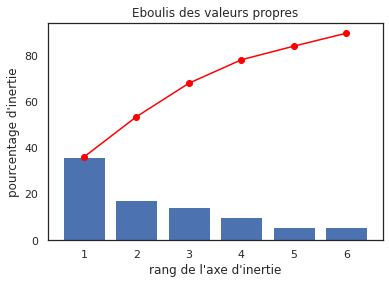

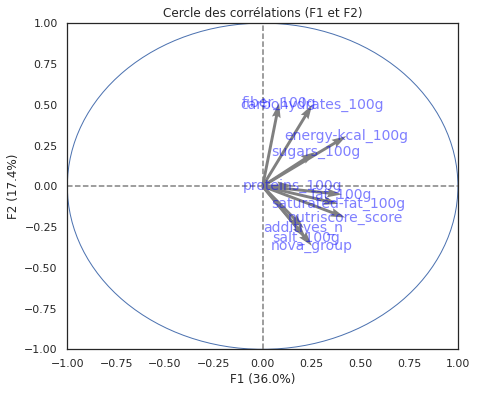

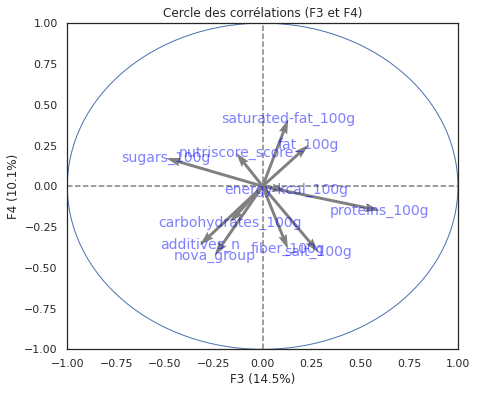

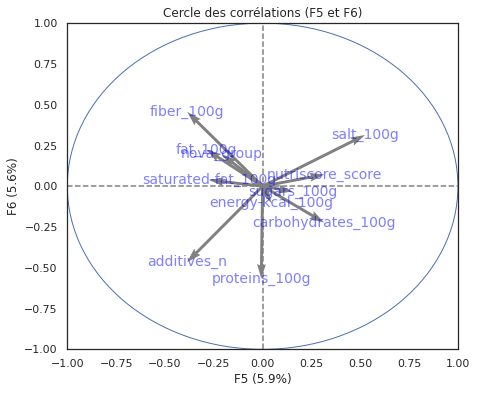

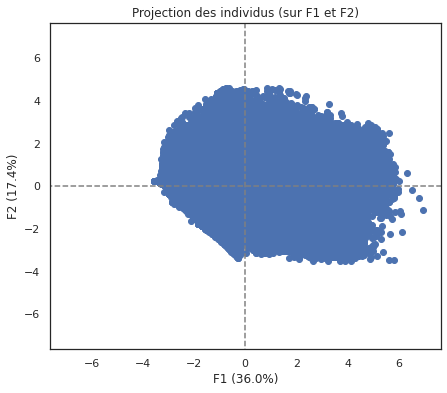

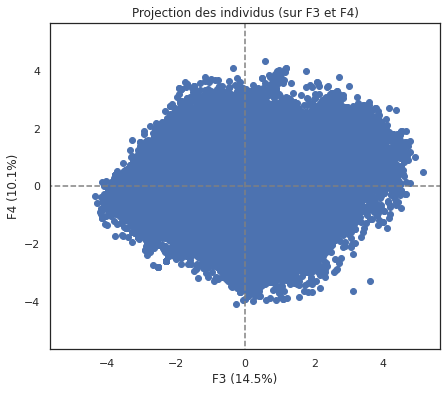

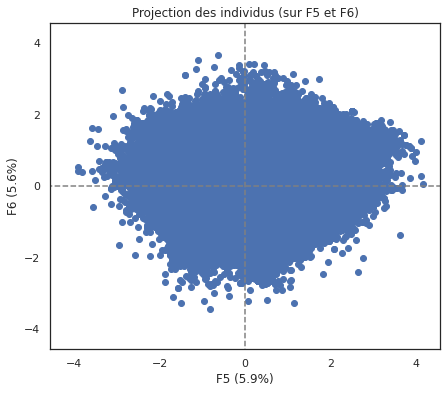

In [ ]:
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn import preprocessing
# from functions import *

# choix du nombre de composantes à calculer
n_comp = 6

# import de l'échantillon
# data = pd.read_csv("my_courses.csv",decimal=".",index_col=0)

col_pca = ['additives_n',
 'nova_group',
 'energy-kcal_100g',
 'fat_100g',
 'proteins_100g',
 'carbohydrates_100g',
 'fiber_100g',
 'saturated-fat_100g',
 'sugars_100g',
 'salt_100g',
 'nutriscore_score']

# selection des colonnes à prendre en compte dans l'ACP
data_pca = df_final[col_pca]

# préparation des données pour l'ACP
# data_pca = data_pca.fillna(data_pca.mean()) # Il est fréquent de remplacer les valeurs inconnues par la moyenne de la variable
X = data_pca.values
# names = data["idCours"] # ou data.index pour avoir les intitulés
features = col_pca

# Centrage et Réduction (already done for KNN Imputing)
# std_scale = preprocessing.StandardScaler().fit(X)
# X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X)

# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))

# Projection des individus
X_projected = pca.transform(X)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)])#, labels = np.array(names))

plt.show()

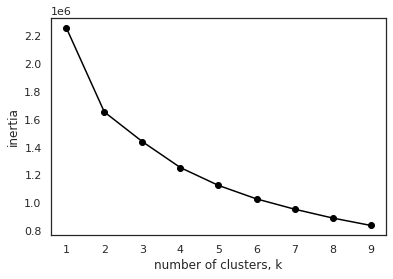

In [ ]:
from sklearn.cluster import KMeans

ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(data_pca.values)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()